In [1]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV

# Data Loading

In [2]:
%run ../util/load_data.py
%run ../util/data_visualization.py
%run ../util/outliers_statistics.py

import warnings
warnings.filterwarnings('ignore')

data = load_data("../data")

/Users/andrluc/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/andrluc/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


# Classification

Let's create now the estimator pipeline.

In [3]:
classifier = Pipeline([
#     ('scl', StandardScaler()),
#     ('pca', PCA(n_components=5)),
    ('clf', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=100,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))
])

X = data['train_data'][data['numerical_attributes'] + data['categorical_attributes']]
y = data['train_data'][data['target']]

## Learning curve

<module 'matplotlib.pyplot' from '/Users/andrluc/.pyenv/versions/3.6.4/lib/python3.6/site-packages/matplotlib/pyplot.py'>

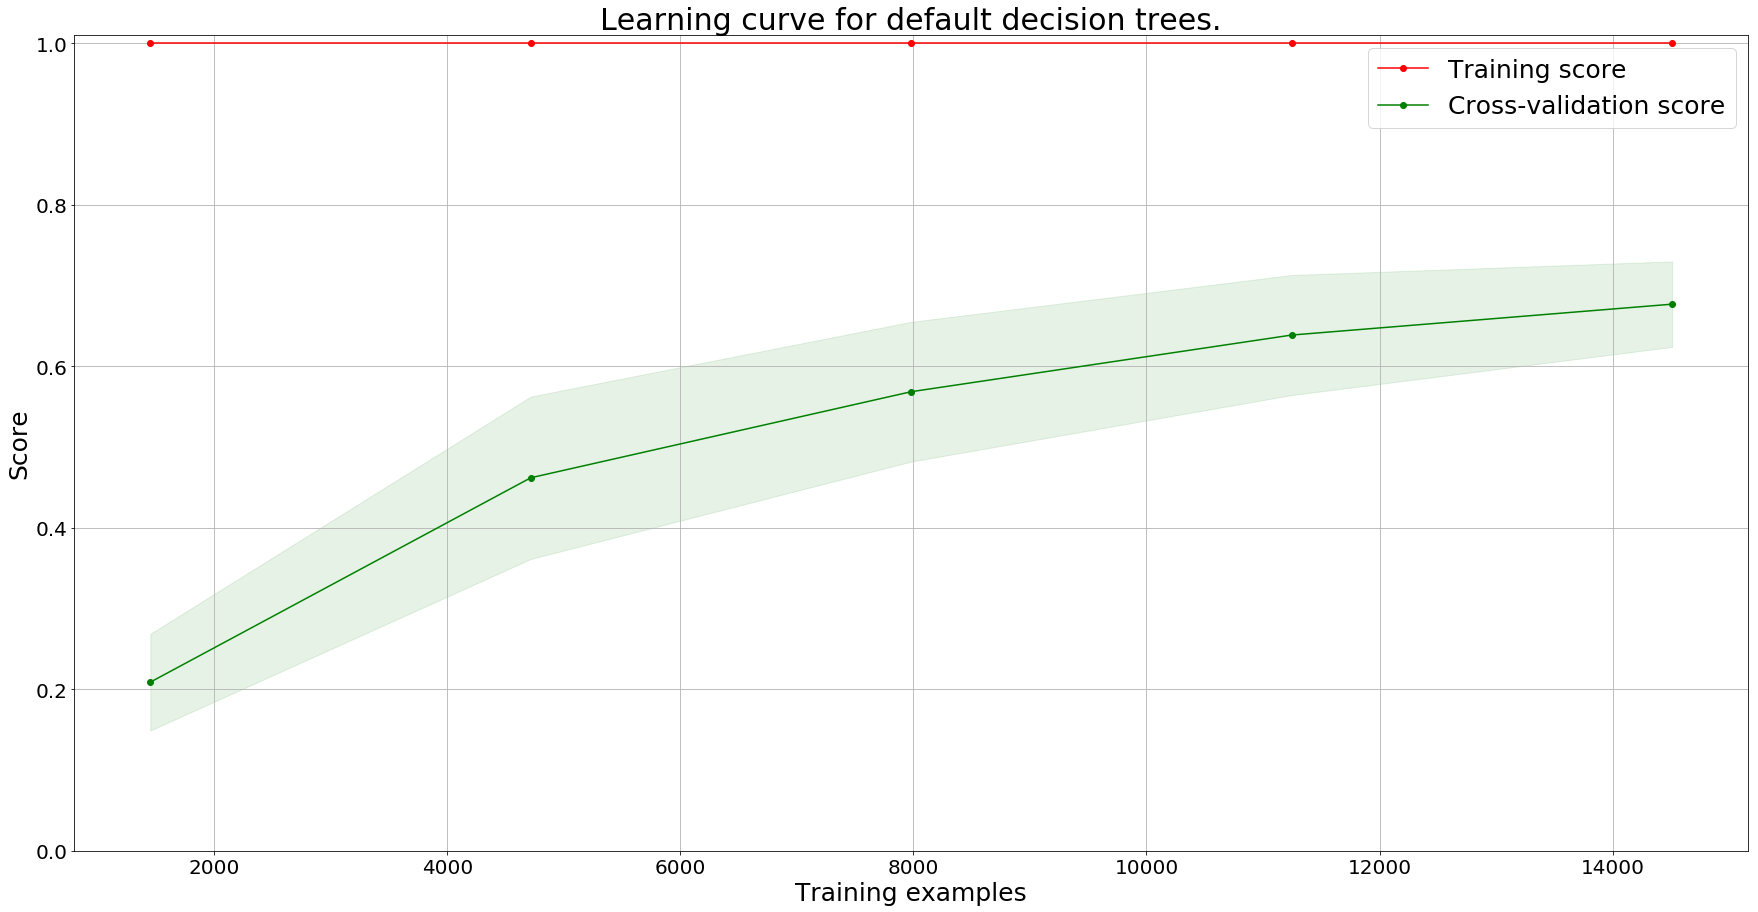

In [4]:
kfold = StratifiedKFold(n_splits = 25)
plot_learning_curve(classifier, 'Learning curve for default decision trees.', 
                    X, y, ylim=(0, 1.01), cv=kfold, n_jobs=10)

## Validation curve with tree max_depth

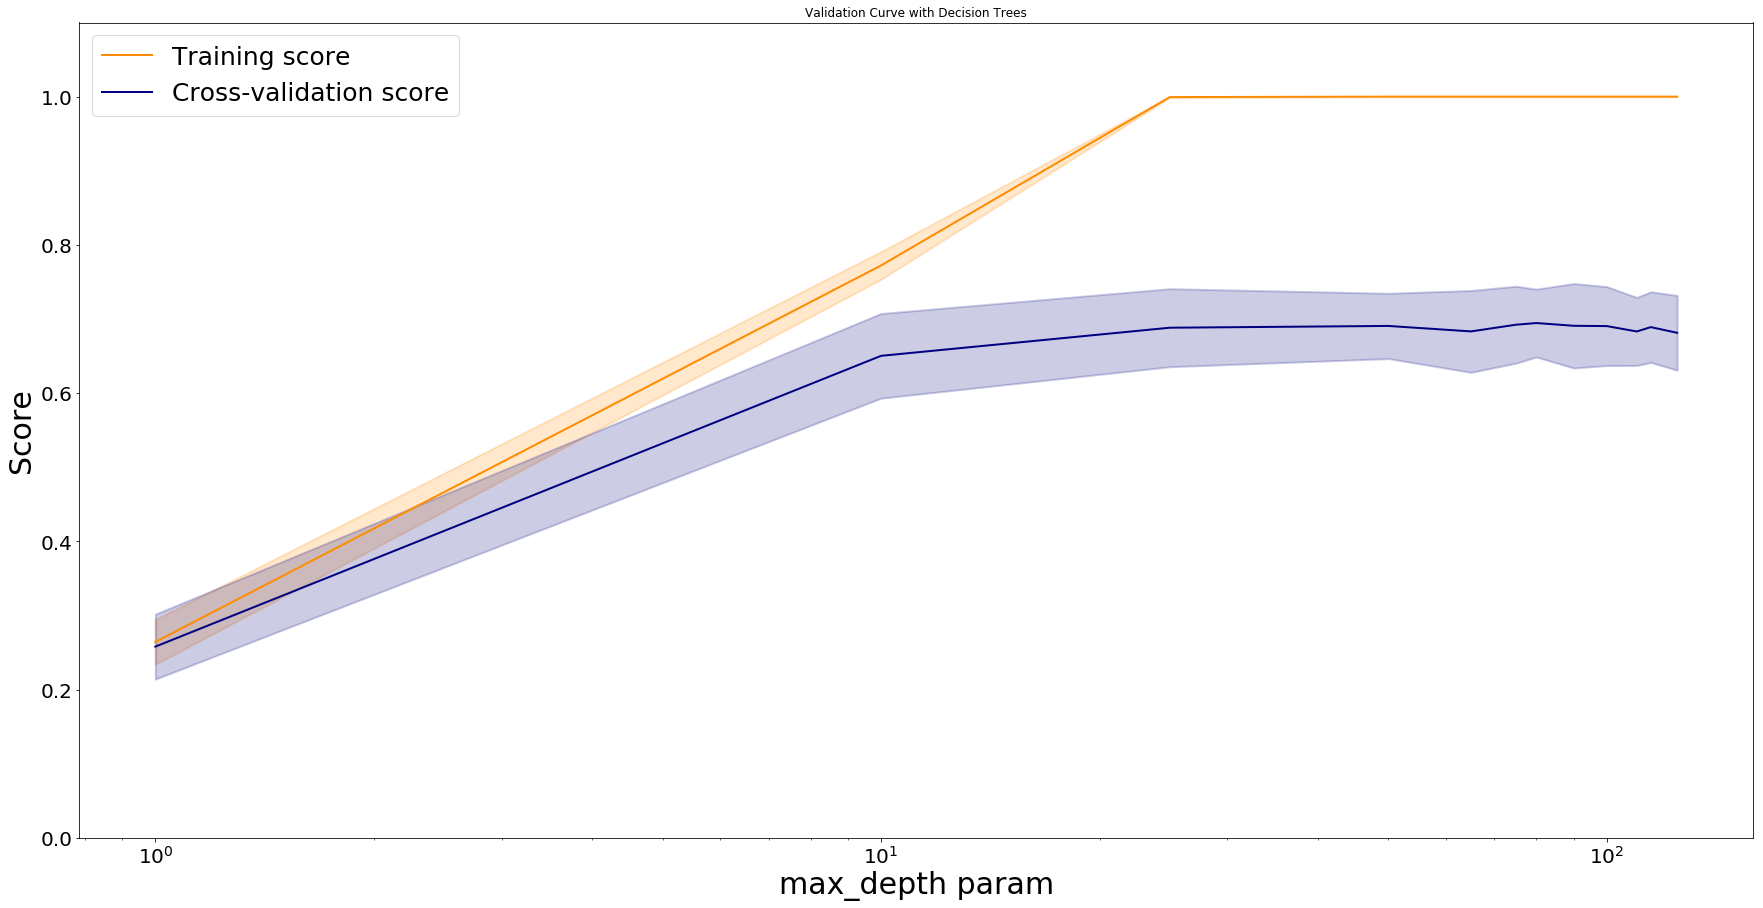

In [ ]:
param_range = [1, 10, 25, 50, 65, 75, 80, 90, 100, 110, 115, 125]

train_scores, test_scores = validation_curve(
    estimator = classifier,
    X = X,
    y = y,
    param_name = 'clf__max_depth',
    param_range = param_range,
    cv = 25
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(30, 15))
plt.title("Validation Curve with Decision Trees")
plt.xlabel("max_depth param", fontsize=30)
plt.ylabel("Score", fontsize=30)
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best", prop={'size': 25})
plt.tick_params(labelsize=20)

plt.show()


## Fetching the classifier results 

In [ ]:
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

y_predicted_total = [None] * len(X)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    classifier.fit(X_train, y_train)
    
    y_predicted = classifier.predict(X_test).tolist()
    for idx, index in enumerate(test_index):
        y_predicted_total[index] = y_predicted[idx]

## Confusion matrix

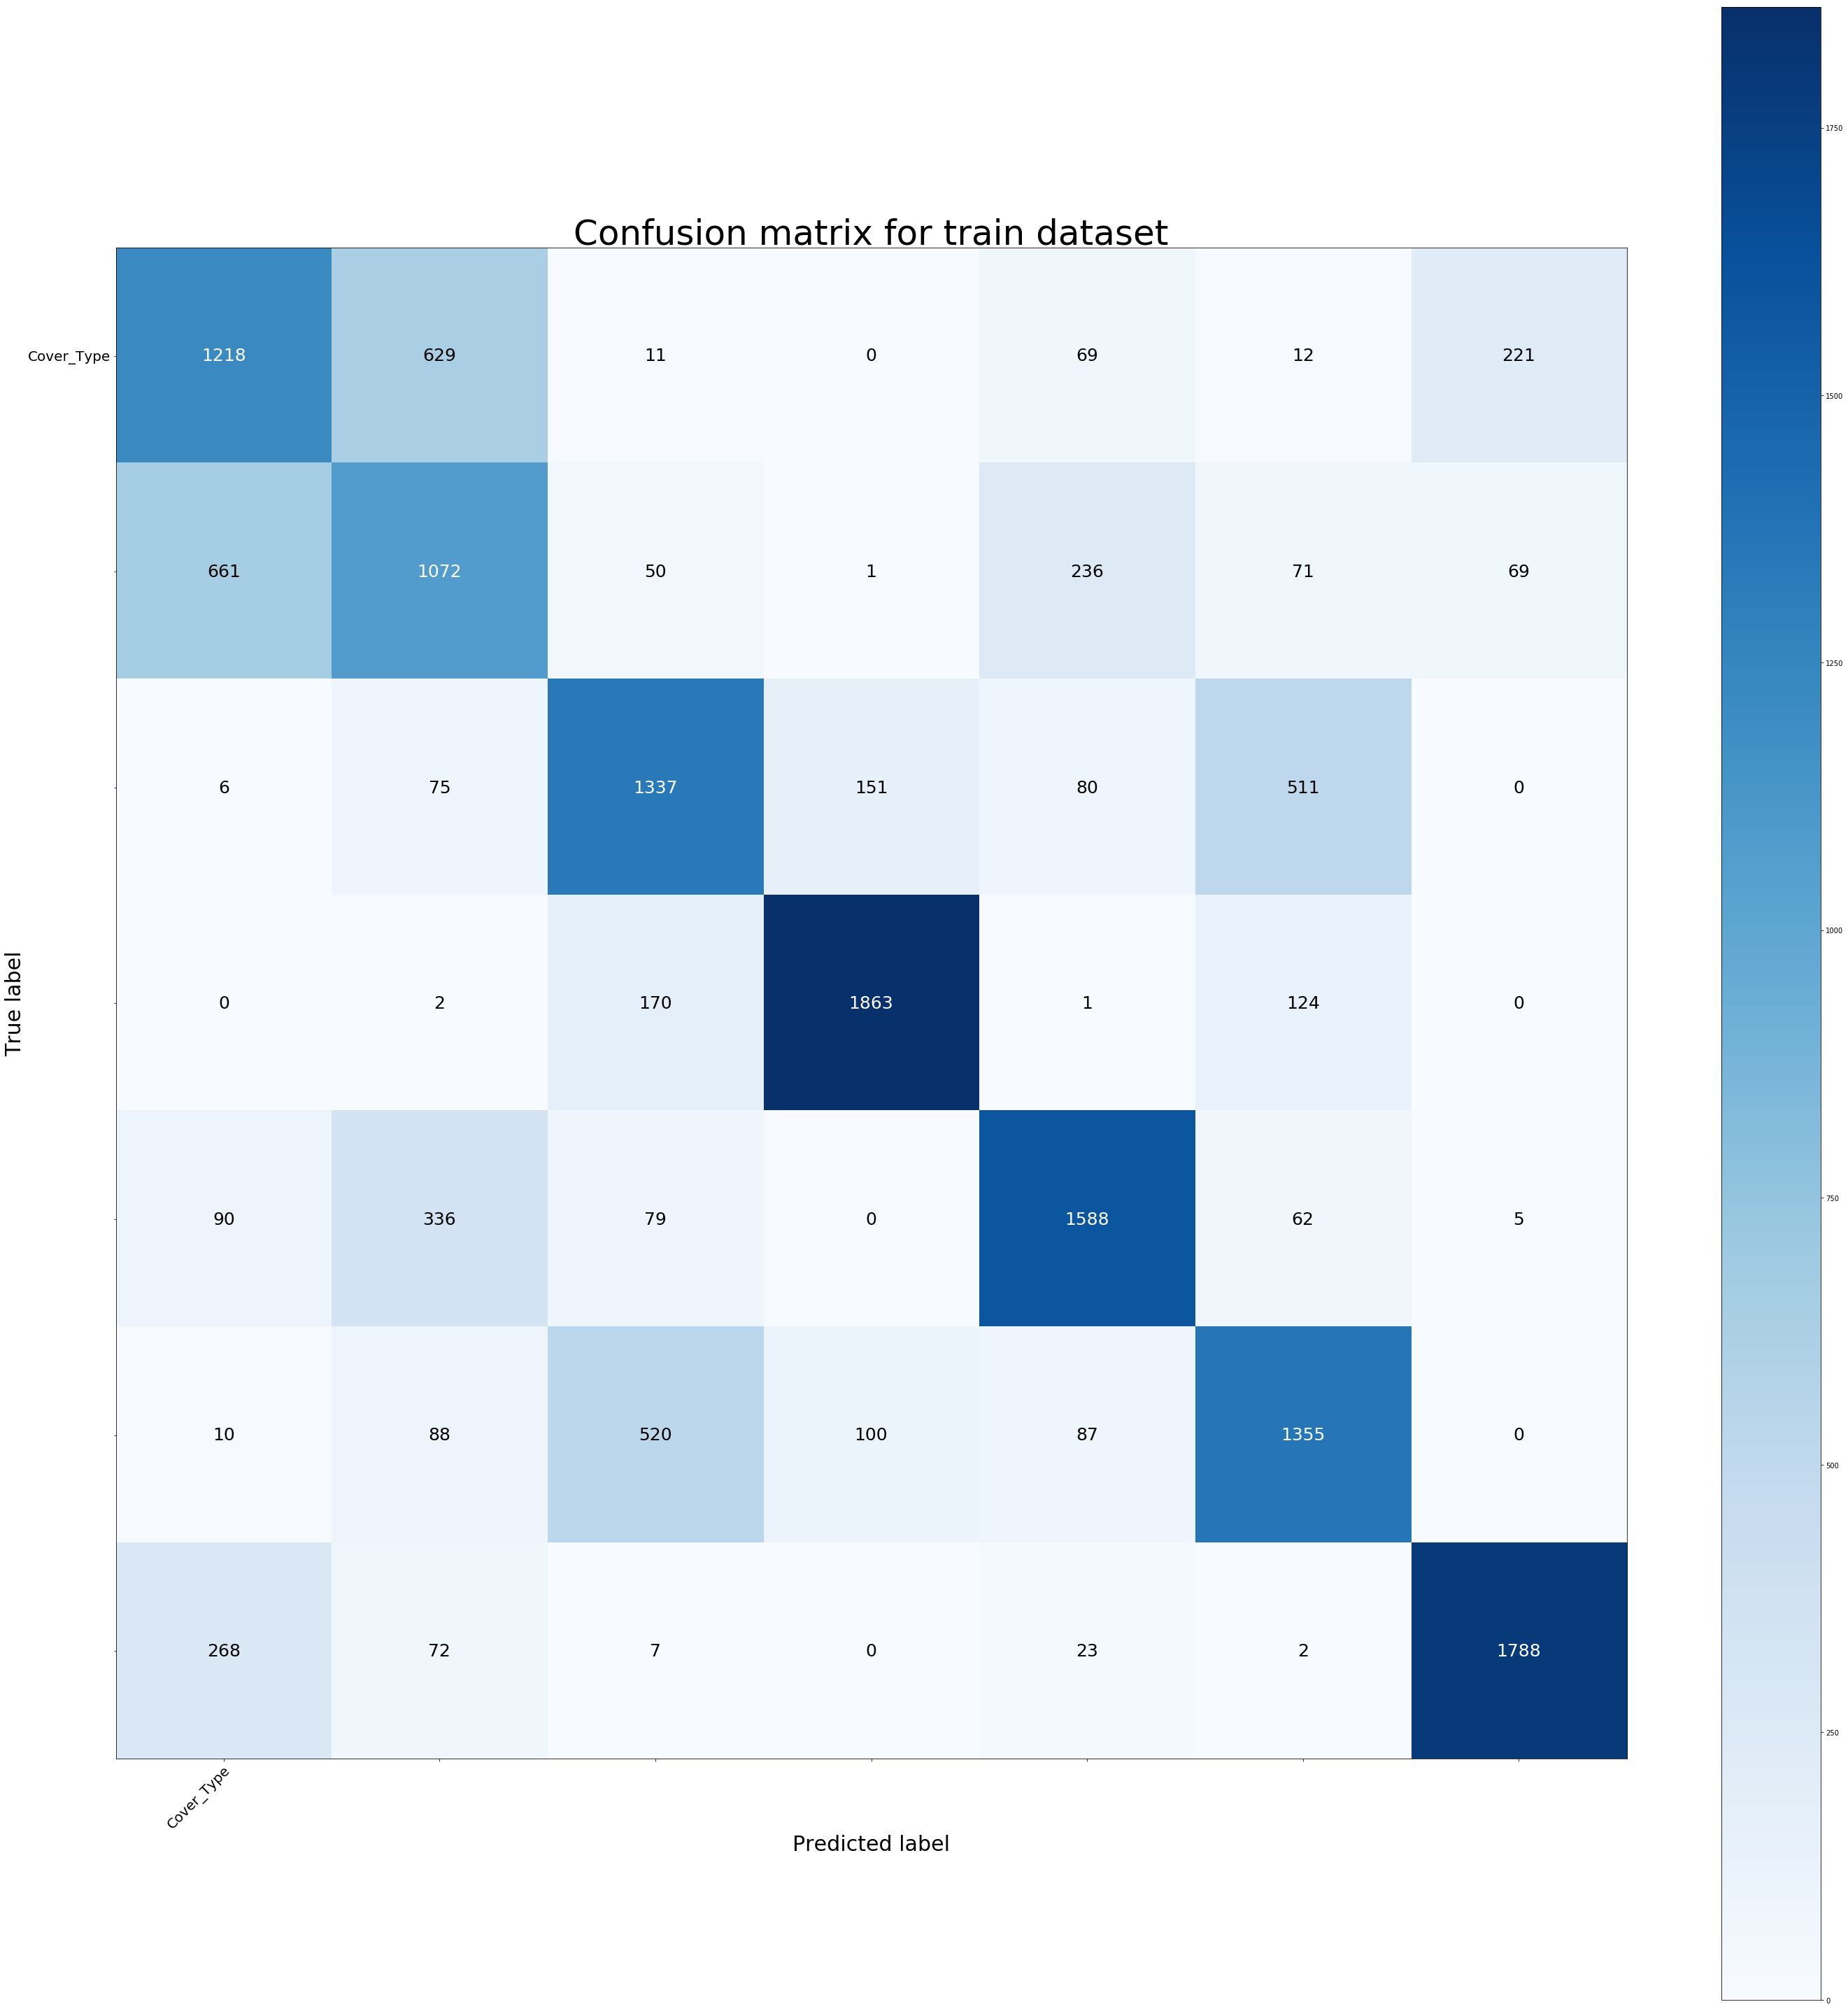

In [ ]:
plot_confusion_matrix(y, y_predicted_total, classes=list(set(y[data['target']])),
                  title='Confusion matrix for train dataset')

## Classification results (precision, recall, F1-score)

In [ ]:
target_names = ['Class ' + str(index) for index in list(set(y[data['target'][0]].tolist()))]
print(classification_report(y, y_predicted_total, target_names=target_names))

              precision    recall  f1-score   support

     Class 1       0.54      0.56      0.55      2160
     Class 2       0.47      0.50      0.48      2160
     Class 3       0.61      0.62      0.62      2160
     Class 4       0.88      0.86      0.87      2160
     Class 5       0.76      0.74      0.75      2160
     Class 6       0.63      0.63      0.63      2160
     Class 7       0.86      0.83      0.84      2160

   micro avg       0.68      0.68      0.68     15120
   macro avg       0.68      0.68      0.68     15120
weighted avg       0.68      0.68      0.68     15120



## Hyperparameters optimization

In [ ]:
print("Fitting the classifier to the training set")
t0 = time()

param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__splitter': ['random', 'best'],
    'clf__max_depth': [10, 25, 100],
    'clf__min_samples_split': [2, 3, 5, 15],
    'clf__min_samples_leaf': [1, 5, 15],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__presort': [True, False]
}

search = GridSearchCV(classifier, param_grid, cv=5)

search = search.fit(X, y)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(search.best_estimator_)

Fitting the classifier to the training set
